In [1]:
# This file is created to run kmeans using the HOMA2 three cohort of the DE project (DDP,DPPOS, and JHS)
# Updated in April 2024 to run k means using the six cohorts of the DE project (DDP,DPPOS,JHS,ARIC,CHS,FHS)
# Updated in April 2024 to try new initialization methods for kmeans    

In [3]:
# import the necessary packages
import matplotlib.pyplot as plt
import seaborn as sns
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import pandas as pd 
import numpy as np

In [22]:
# read the data

path = '/Users/zhongyuli/Desktop/python/cluster analysis/dataset/data_array_homa2.csv'

data_6c = pd.read_csv(path) 
data_6c[:10]




,study_id,bmi,hba1c,ldlc,hdlc,tgl,sbp,dbp,ratio_th,dmagediag,glucosef2,insulinf2,study,homa2b,homa2ir
0,3278,33.87268,6.4,48.0,31.0,768,124.00000,78.00000,24.774193,56.01644,8.6025,1850.4,dppos,485.1,27.027027
1,8663,30.12909,9.6,97.0,36.0,197,121.66667,81.66667,5.472222,58.00000,9.5460,1806.0,mesa,427.8,27.027027
2,8543,22.68000,6.0,64.0,80.0,103,98.33333,46.33333,1.287500,77.00000,7.6590,1554.0,mesa,489.7,23.255814
3,8613,29.81743,7.7,NaN,34.0,417,73.33333,37.33333,12.264706,79.00000,9.9345,1464.0,mesa,348.6,23.255814
4,2932,39.92760,6.1,100.0,45.0,252,113.00000,70.00000,5.600000,40.03288,10.1565,1238.4,dppos,297.6,20.833333
5,8535,39.66473,5.7,160.0,63.0,66,169.00000,81.00000,1.047619,88.00000,9.8235,1278.0,mesa,316.2,20.833333
6,8577,34.68809,5.6,114.0,35.0,112,154.00000,92.00000,3.200000,70.00000,4.9395,1518.0,mesa,911.0,20.408163
7,8588,28.96452,6.8,111.0,37.0,139,170.66667,81.33333,3.756757,79.00000,9.1575,1182.0,mesa,321.2,19.607843
8,8491,30.56805,7.0,56.0,46.0,171,120.33333,66.33333,3.717391,70.00000,7.4925,1176.0,mesa,412.2,18.518519
9,8622,29.87548,7.1,91.0,38.0,284,136.33333,75.00000,7.473684,73.00000,6.1050,1116.0,mesa,534.8,17.241379


In [23]:
# preprocessing - standardize the data
study_id = data_6c['study_id']
study = data_6c['study']

# drop id and study site
data_to_scale = data_6c.drop(['study_id', 'study'], axis=1)
scaler = StandardScaler() 
scaled_data = scaler.fit_transform(data_to_scale)

# Convert scaled data back to a DataFrame and add study_id and study back

scaled_data_df = pd.DataFrame(scaled_data, columns=data_to_scale.columns)
scaled_data_df['study_id'] = study_id.values
scaled_data_df['study'] = study.values
scaled_data_df[:5]
# remove missing values
data_6c_clean = data_6c.dropna()
scaled_data_df= scaled_data_df.dropna()
scaled_data_df[:10]




,bmi,hba1c,ldlc,hdlc,tgl,sbp,dbp,ratio_th,dmagediag,glucosef2,insulinf2,homa2b,homa2ir,study_id,study
0,0.115472,0.083610,-1.724126,-1.242539,6.772583,-0.030108,0.230617,6.513853,-0.542181,0.992807,10.720668,4.497958,8.850779,3278,dppos
1,-0.411339,3.405091,-0.303114,-0.864157,0.515186,-0.154445,0.464804,0.569752,-0.389744,1.564560,10.436166,3.794652,8.850779,8663,mesa
2,-1.459601,-0.331575,-1.260122,2.465599,-0.514928,-1.397818,-1.791911,-0.718946,1.070411,0.421055,8.821425,4.554418,7.439654,8543,mesa
4,0.967542,-0.227778,-0.216114,-0.183071,1.117913,-0.616269,-0.280338,0.609102,-1.770521,1.934518,6.799154,2.196566,6.533202,2932,dppos
5,0.930550,-0.642964,1.523901,1.179102,-0.920398,2.367824,0.422225,-0.792818,1.915764,1.732723,7.052899,2.424864,6.533202,8535,mesa
6,0.230220,-0.746760,0.189890,-0.939834,-0.416300,1.568513,1.124787,-0.129986,0.532459,-1.226938,8.590748,9.725491,6.374111,8577,mesa
7,-0.575221,0.498795,0.102889,-0.788481,-0.120416,2.456636,0.443514,0.041469,1.224111,1.329132,6.437760,2.486235,6.074644,8588,mesa
8,-0.349567,0.706388,-1.492124,-0.107395,0.230261,-0.225495,-0.514525,0.029347,0.532459,0.320157,6.399314,3.603177,5.667037,8491,mesa
9,-0.447028,0.810184,-0.477116,-0.712805,1.468590,0.627103,0.039009,1.186108,0.763010,-0.520656,6.014851,5.107980,5.189153,8622,mesa
10,0.346808,0.394999,0.682894,-0.788481,-0.964233,-0.136683,-1.004189,-0.599406,-0.082343,0.387422,5.438158,3.031204,5.079807,8590,mesa


In [24]:
scaled_data_df.shape

(3446, 15)

In [25]:
#%pip install scipy
# use hierarchical clustering to find the initial cluster centers
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

In [26]:
# Select initial centroids for k-means based on hierarchical clustering
# Perform hierarchical clustering with k clusters

k = 4

# select five variables to cluster
selected_variables = ['bmi', 'hba1c', 'dmagediag','homa2b','homa2ir']
data_to_cluster = scaled_data_df[selected_variables]

X = data_to_cluster.values
Z = linkage(X, method='ward')
agg_clustering = AgglomerativeClustering(n_clusters=k, linkage='ward')
agg_labels = agg_clustering.fit_predict(X)

# Calculate the centroids based on the hierarchical clustering
initial_centroids = np.array([X[agg_labels == i].mean(axis=0) for i in range(k)])
print(initial_centroids)



[[ 0.35499336 -0.02240713 -0.74834371  0.20377337  0.21881575]
 [-0.41575485 -0.20640865  0.85715217 -0.44297385 -0.51965163]
 [ 0.18561602  0.11762761 -0.02044853  3.29774776  3.17597836]
 [ 0.02964386  4.31483495 -0.3425994  -0.84134258  0.33801895]]


In [27]:
kmeans = KMeans(
    init=initial_centroids, n_clusters=4, n_init=10, max_iter=300, random_state=57
)

# "init" controls the initialization technique. The standard version of the k-means algorithm is implemented by setting init to "random". 
# Setting this to "k-means++" employs an advanced trick to speed up convergence

#"n_clusters" sets k for the clustering step. This is the most important parameter for k-means.

# "n_init" sets the number of initializations to perform. This is important because two runs can converge on different cluster assignments. 
#The default behavior for the scikit-learn algorithm is to perform ten k-means runs and return the results of the one with the lowest SSE.

In [28]:
kmeans.fit(data_to_cluster)

# Add the labels to the scaled dataset
scaled_data_df['cluster'] = kmeans.labels_




/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1431: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)


In [29]:
# The lowest SSE value
kmeans.inertia_

8638.854385290475

In [30]:
# Final locations of the centroid
kmeans.cluster_centers_

array([[ 0.66325248, -0.06251062, -0.86331459,  0.19475974,  0.22840522],
       [-0.56030967, -0.24834473,  0.68839917, -0.42114999, -0.52460649],
       [ 0.14720343,  0.02684014,  0.12149152,  2.40037614,  2.33572254],
       [ 0.2972747 ,  3.24387564, -0.47301942, -0.81050681,  0.06349867]])

In [31]:
# The number of iterations required to converge
kmeans.n_iter_

11

In [32]:
kmeans.labels_[:5]

array([2, 2, 2, 2, 2], dtype=int32)

In [33]:
# HOW to choose the number of clusters
# 1) The elbow method: 

kmeans_kwargs = { # set the parameters for the kmeans algorithm
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 57,
}

# A list holds the SSE values for each k
sse = [] #initiate an empty list to store the sum of squared errors 
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(data_to_cluster)
    sse.append(kmeans.inertia_)

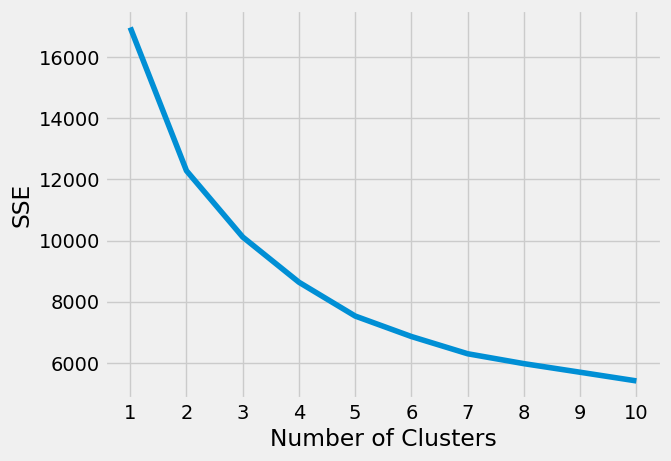

In [34]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [35]:
# Determining the elbow point in the SSE curve isn’t always straightforward. 
# If you’re having trouble choosing the elbow point of the curve, then you could use a Python package:
# kneed, to identify the elbow point programmatically:

kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
kl.elbow # returns the elbow point

4

In [36]:
cluster_summary = scaled_data_df.groupby('cluster').describe()
print(cluster_summary)
data_to_plot = scaled_data_df[selected_variables + ['cluster']]

            bmi                                                              \
          count      mean       std       min       25%       50%       75%   
cluster                                                                       
0        1339.0  0.663252  0.971251 -1.846942 -0.043824  0.518749  1.216401   
1        1721.0 -0.560310  0.641400 -2.414207 -0.989468 -0.622231 -0.164531   
2         245.0  0.147203  0.898581 -1.580354 -0.485670  0.053127  0.664352   
3         141.0  0.297275  1.006060 -1.996153 -0.457056  0.246698  0.971312   

                    hba1c            ...   homa2ir           study_id  \
              max   count      mean  ...       75%       max    count   
cluster                              ...                                
0        5.749375  1339.0 -0.062511  ...  0.661552  2.517347   1339.0   
1        1.867371  1721.0 -0.248345  ... -0.300371  1.391500   1721.0   
2        3.698343   245.0  0.026840  ...  2.942024  8.850779    245.0   
3       

In [43]:
# add cluster labels to the original dataset
data_6c_clean['cluster'] = scaled_data_df['cluster']
# summarize the data by cluster, show the mean of each variable

cluster_summary_or_homa2 = data_6c_clean[selected_variables + ['cluster']].groupby('cluster').mean()
print(cluster_summary_or_homa2)

# save the summary data
cluster_summary_or_homa2.to_csv('/Users/zhongyuli/Desktop/python/cluster analysis/dataset/cluster_summary_or_homa2.csv') 





               bmi     hba1c  dmagediag      homa2b   homa2ir
cluster                                                      
0        37.765280  6.259223  51.837744  134.507916  3.983843
1        29.070484  6.080186  72.029140   84.328239  1.971429
2        34.098166  6.345306  64.652356  314.204898  9.615622
3        35.164593  9.444681  56.916390   52.606383  3.543132


/var/folders/mw/svm2x9qn5fx658rhfzs94mxh0000gn/T/ipykernel_85478/628646146.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_6c_clean['cluster'] = scaled_data_df['cluster']


In [42]:
data_6c_clean.shape

(3446, 15)

In [41]:
scaled_data_df.shape

(3446, 16)

In [44]:
# report the sample size by study
sample_size_by_study = data_6c_clean.groupby(['study']).size()
print(sample_size_by_study)


study
aric      1245
cardia     357
dpp        685
dppos      860
jhs         90
mesa       209
dtype: int64


In [45]:
# sample size in each cluster
cluster_size = data_6c_clean.groupby('cluster').size()
print(cluster_size)

cluster
0    1339
1    1721
2     245
3     141
dtype: int64


In [46]:
# rename the cluster labels
data_to_plot['cluster'] = data_6c_clean['cluster'].replace({0:'MOD', 1:'MARD', 2:'SIRD', 3:'SIDD'})

/var/folders/mw/svm2x9qn5fx658rhfzs94mxh0000gn/T/ipykernel_85478/13812285.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_plot['cluster'] = data_6c_clean['cluster'].replace({0:'MOD', 1:'MARD', 2:'SIRD', 3:'SIDD'})


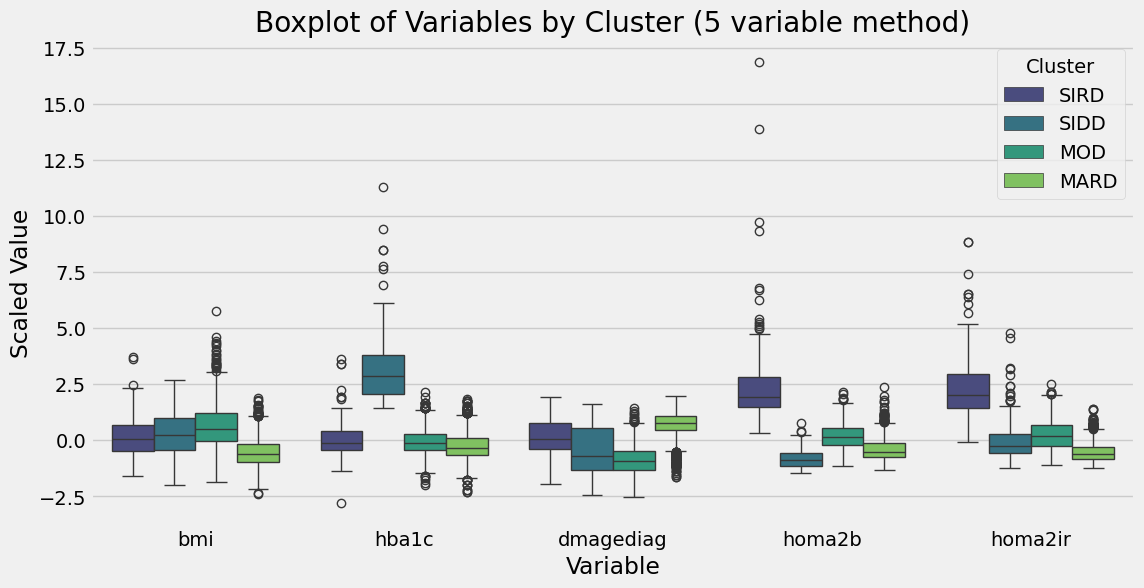

In [47]:
melted_data = pd.melt(data_to_plot, id_vars=['cluster'], var_name='Variable', value_name='Value')

plt.figure(figsize=(12, 6))
sns.boxplot(data=melted_data, x='Variable', y='Value', hue='cluster', palette='viridis')
plt.title('Boxplot of Variables by Cluster (5 variable method)')
plt.xlabel('Variable')
plt.ylabel('Scaled Value')
plt.legend(title='Cluster', loc='upper right')
plt.show()

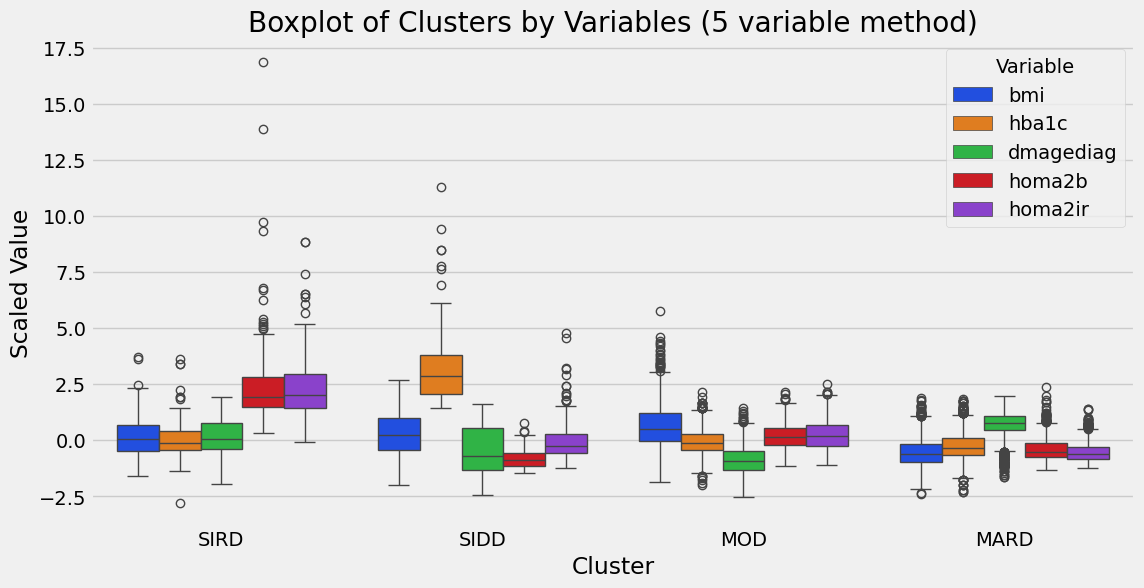

In [48]:
melted_data2 = pd.melt(data_to_plot, id_vars=['cluster'], var_name='Variable', value_name='Value')
plt.figure(figsize=(12, 6))
sns.boxplot(data=melted_data2, x='cluster', y='Value', hue='Variable', palette='bright')
plt.title('Boxplot of Clusters by Variables (5 variable method)')
plt.xlabel('Cluster')
plt.ylabel('Scaled Value')
plt.legend(title='Variable', loc='upper right')
plt.show()

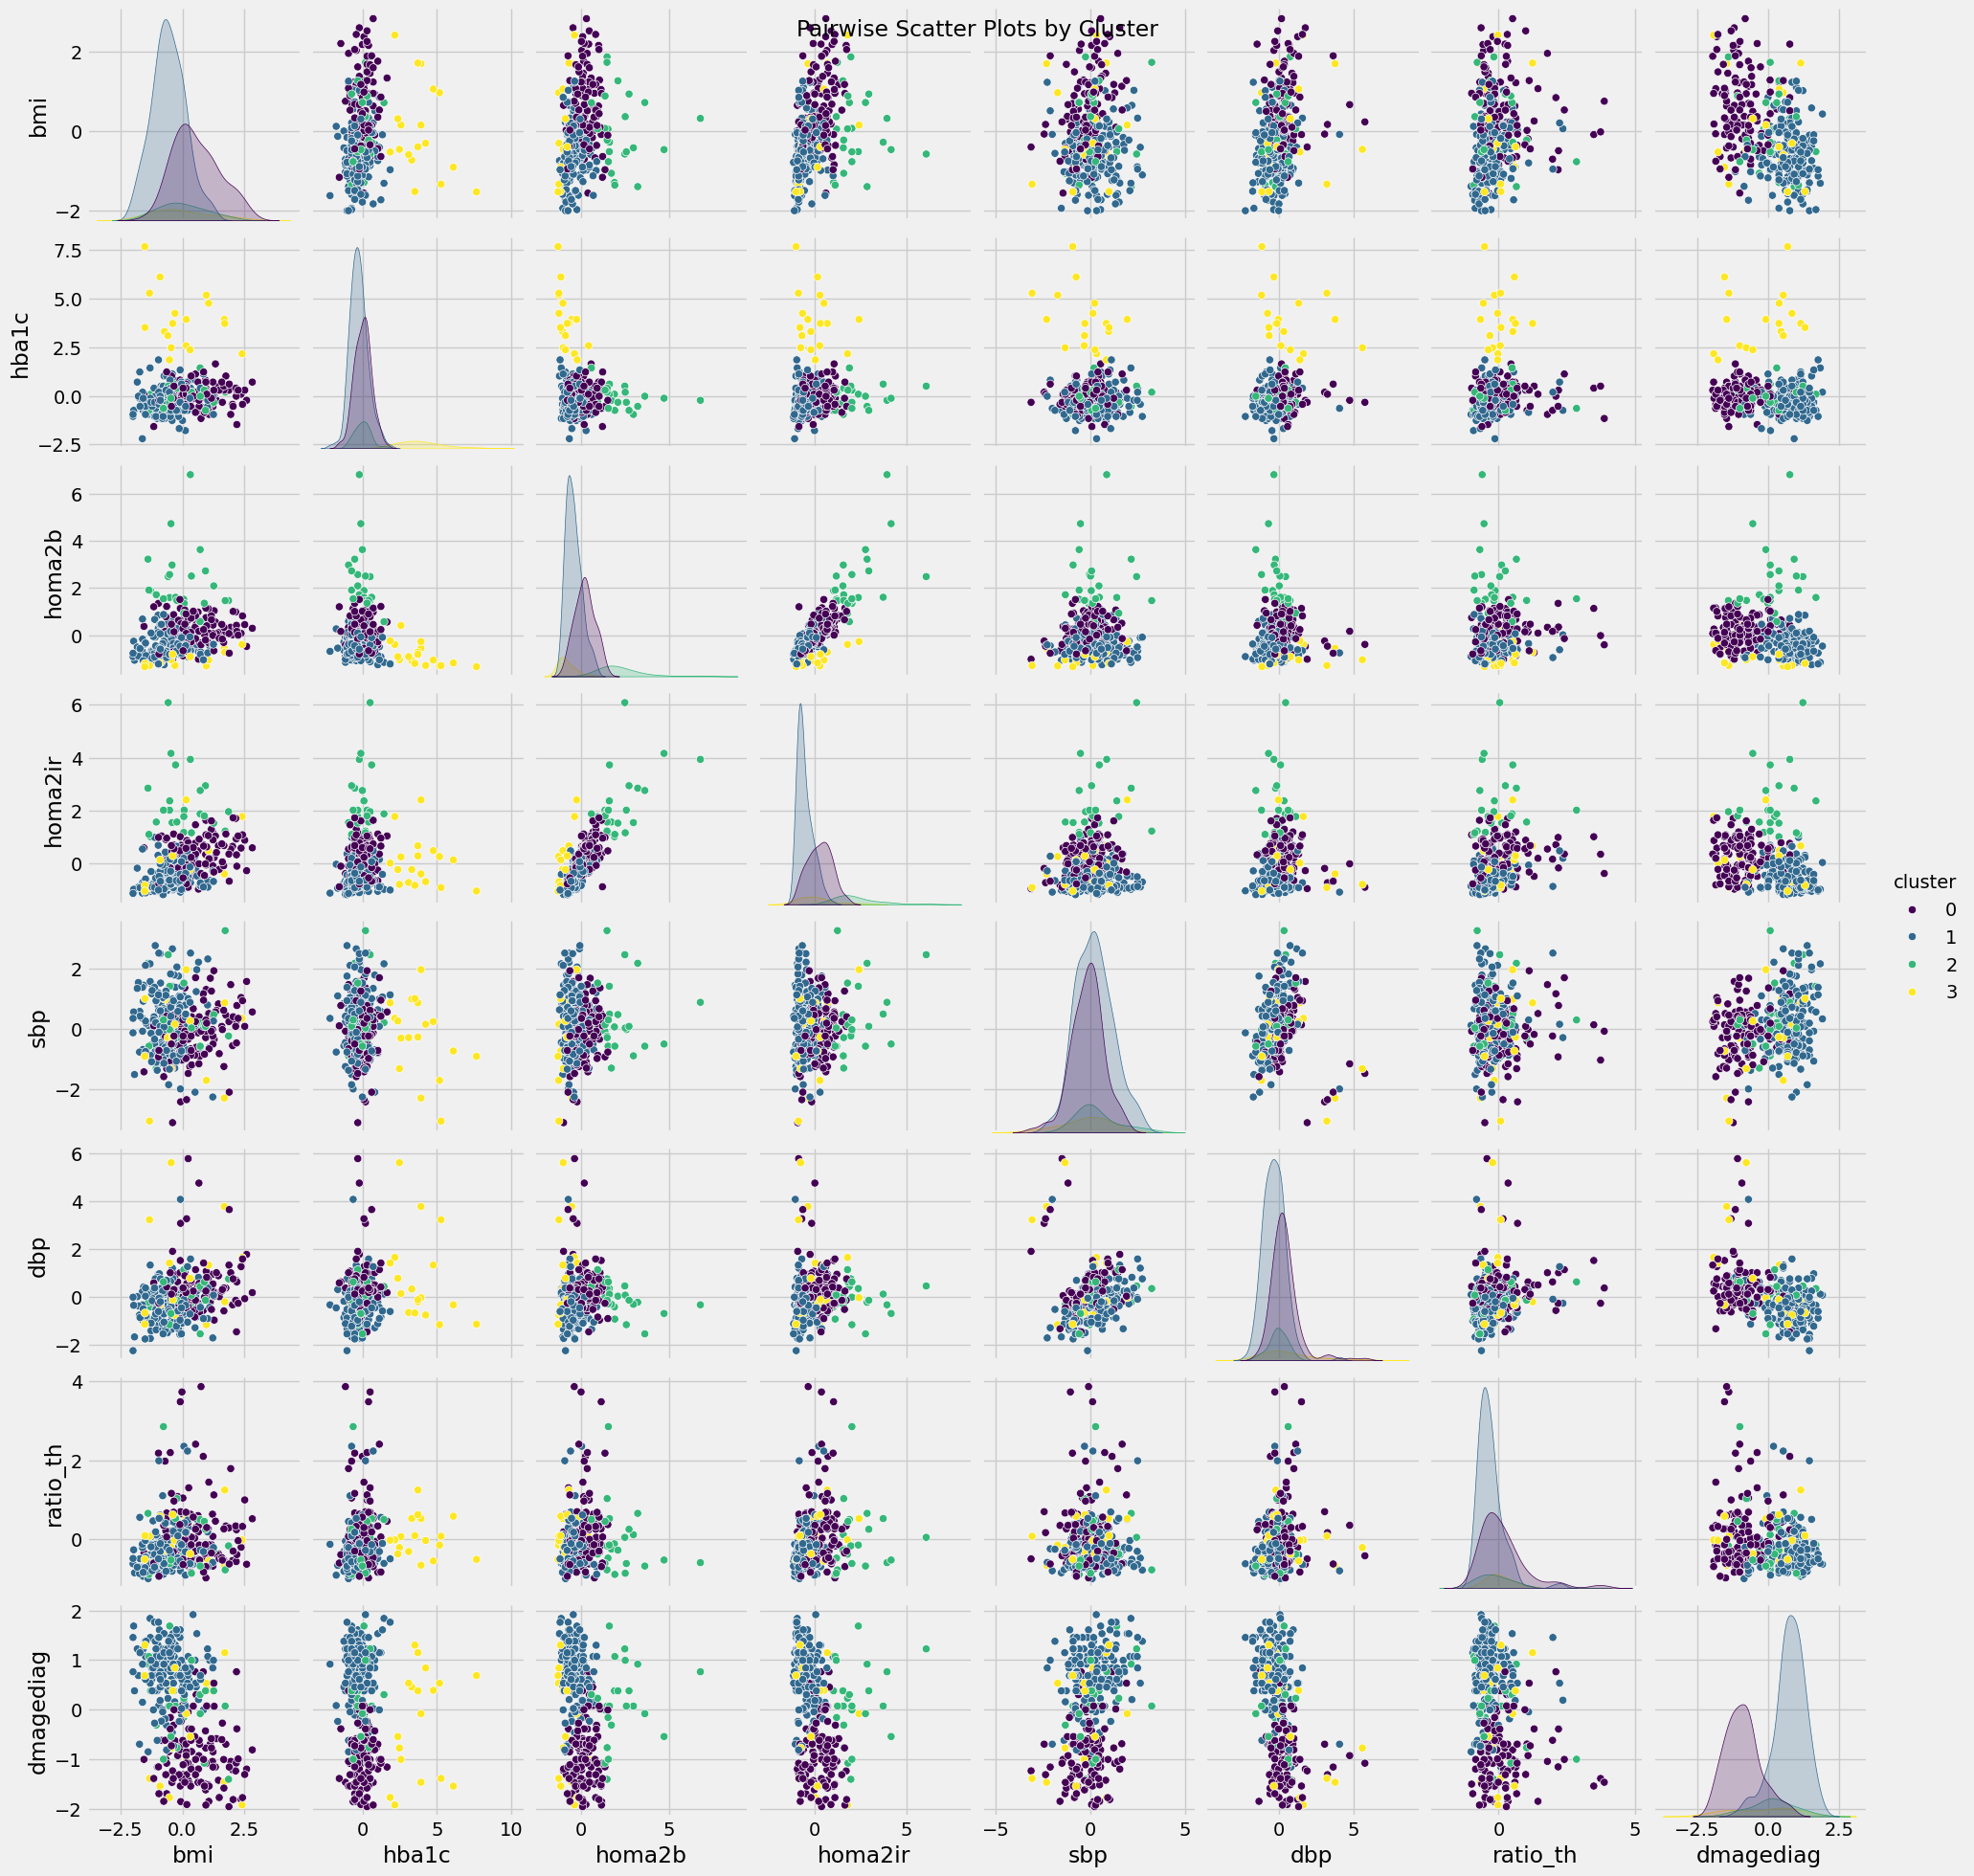

In [124]:
# Sampled to reduce overplotting and improve performance
sampled_df = scaled_data_df.sample(frac=0.1)  # Adjust frac as needed

sns.pairplot(sampled_df, vars=['bmi', 'hba1c', 'homa2b','homa2ir','sbp', 'dbp', 'ratio_th', 'dmagediag'], hue='cluster', palette='viridis')
plt.suptitle('Pairwise Scatter Plots by Cluster')
plt.show()


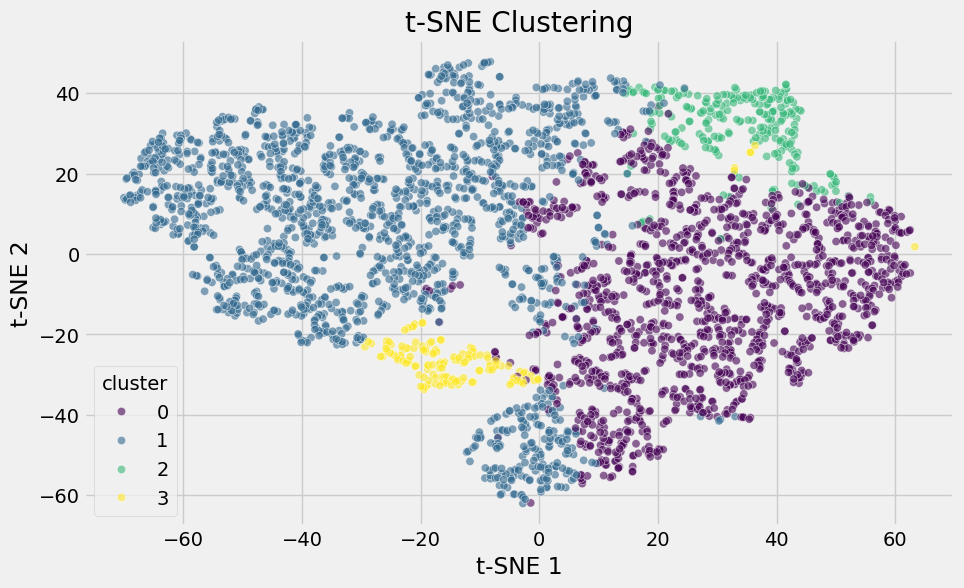

In [49]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
var_drop=['cluster', 'study_id']
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(data_to_plot.drop('cluster', axis=1))

plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=scaled_data_df['cluster'], palette='viridis', alpha=0.6)
plt.title('t-SNE Clustering')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


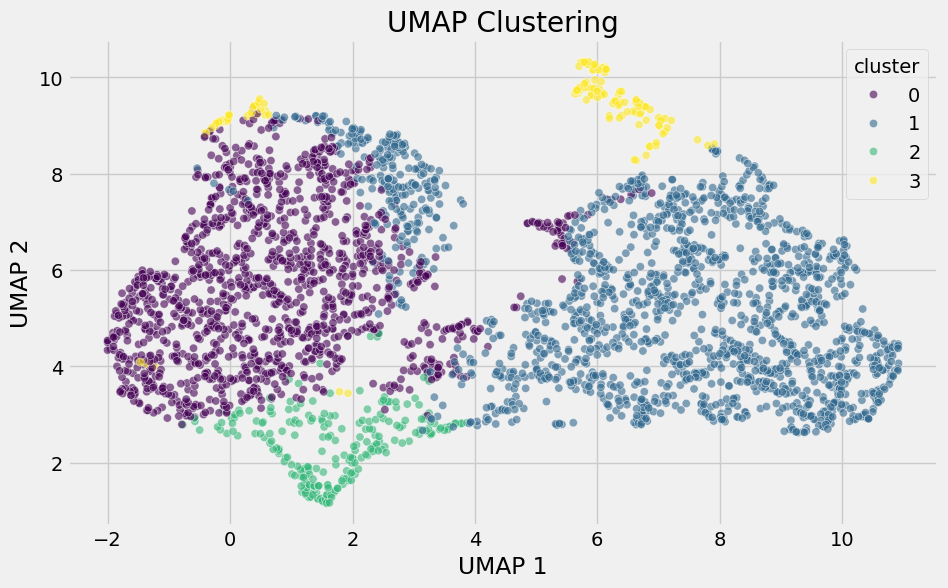

In [50]:
import umap.umap_ as umap

reducer = umap.UMAP()
embedding = reducer.fit_transform(data_to_plot.drop('cluster', axis=1))

plt.figure(figsize=(10, 6))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=scaled_data_df['cluster'], palette='viridis', alpha=0.6)
plt.title('UMAP Clustering')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()


In [51]:
scaled_data_df.columns


Index(['bmi', 'hba1c', 'ldlc', 'hdlc', 'tgl', 'sbp', 'dbp', 'ratio_th',
       'dmagediag', 'glucosef2', 'insulinf2', 'homa2b', 'homa2ir', 'study_id',
       'study', 'cluster'],
      dtype='object')

In [55]:
# now let's try our new kmeans model with six cohorts
selected_variables2 = ['bmi', 'hba1c', 'ldlc', 'hdlc', 'tgl', 'sbp', 'dbp', 'ratio_th','dmagediag']

data_to_cluster2 = scaled_data_df[selected_variables2]

In [57]:

k=4
X2 = data_to_cluster2.values
agg_clustering = AgglomerativeClustering(n_clusters=k, linkage='ward')
agg_labels = agg_clustering.fit_predict(X2)

# Calculate the centroids based on the hierarchical clustering
initial_centroids2 = np.array([X2[agg_labels == i].mean(axis=0) for i in range(k)])


kmeans2 = KMeans(init=initial_centroids2, n_clusters=4, n_init=10, max_iter=300, random_state=57)
kmeans2.fit(data_to_cluster2)

# Add the labels to the scaled dataset
scaled_data_df['cluster2'] = kmeans2.labels_



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1431: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)


In [58]:
kmeans2.inertia_


19872.83528142384

In [60]:
cluster_summary2 = scaled_data_df.groupby('cluster2').describe()

# add cluster labels to the original dataset
data_6c_clean['cluster2'] = scaled_data_df['cluster2']
# summarize the data by cluster, show the mean of each variable
cluster_summary_or_homa2_2 = data_6c_clean[selected_variables2 + ['cluster2']+['homa2b']+['homa2ir']].groupby('cluster2').mean()
print(cluster_summary_or_homa2_2)
# save the summary data
cluster_summary_or_homa2_2.to_csv('/Users/zhongyuli/Desktop/python/cluster analysis/dataset/cluster_summary_or_homa2_2.csv')

                bmi     hba1c        ldlc       hdlc         tgl         sbp  \
cluster2                                                                       
0         29.348612  6.119833   96.540323  51.446595  119.860812  126.976696   
1         37.465509  6.456589  124.807442  45.547132  136.633333  125.498018   
2         33.728845  6.433238   94.338682  34.771633  318.541547  126.628194   
3         35.179101  6.861654  111.308271  50.556391  141.601504   80.097744   

                 dbp  ratio_th  dmagediag      homa2b   homa2ir  
cluster2                                                         
0          66.941817  2.538346  72.699249  104.041637  2.576083  
1          78.175051  3.194329  52.785048  136.309225  4.173889  
2          75.837149  9.535616  59.417404  136.160745  4.509836  
3         125.802005  3.198251  50.451128   91.037594  2.345791  


/var/folders/mw/svm2x9qn5fx658rhfzs94mxh0000gn/T/ipykernel_85478/3423275280.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_6c_clean['cluster2'] = scaled_data_df['cluster2']


/var/folders/mw/svm2x9qn5fx658rhfzs94mxh0000gn/T/ipykernel_85478/3534877483.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_plot2['cluster2'] = data_6c_clean['cluster2']


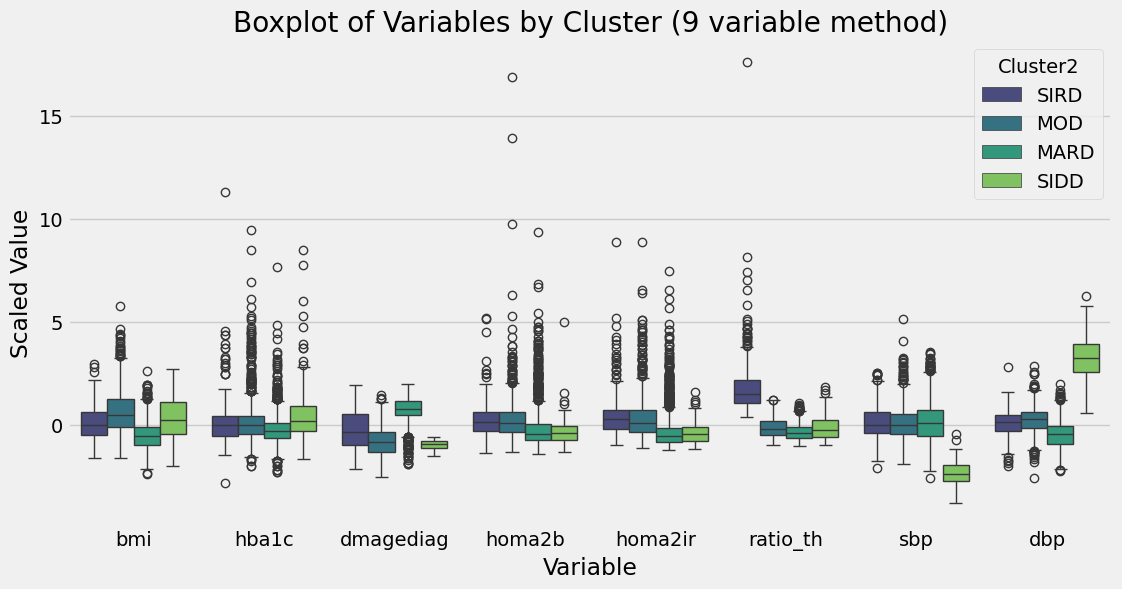

In [85]:
data_to_plot2 = scaled_data_df[selected_variables + ['cluster2']+['ratio_th']+['sbp']+['dbp']]
# rename the cluster labels
data_to_plot2['cluster2'] = data_6c_clean['cluster2']

melted_data3 = pd.melt(data_to_plot2, id_vars=['cluster2'], var_name='Variable', value_name='Value')

plt.figure(figsize=(12, 6))
sns.boxplot(data=melted_data3, x='Variable', y='Value', hue='cluster2', palette='viridis')
plt.title('Boxplot of Variables by Cluster (9 variable method)')
plt.xlabel('Variable')
plt.ylabel('Scaled Value')
plt.legend(title='Cluster2', loc='upper right')
plt.show()

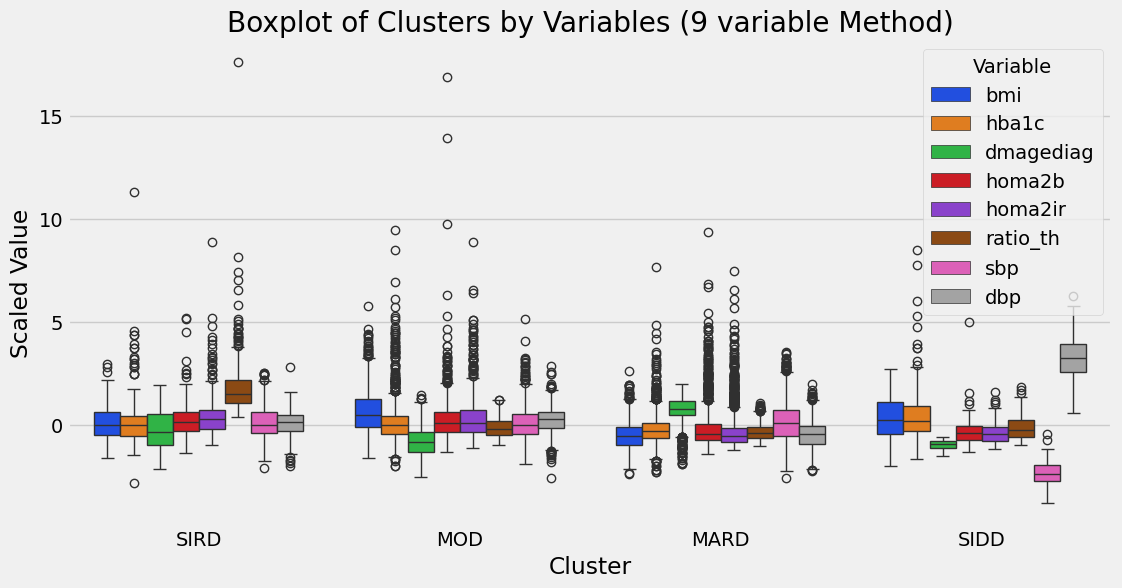

In [62]:
melted_data4 = pd.melt(data_to_plot2, id_vars=['cluster2'], var_name='Variable', value_name='Value')
plt.figure(figsize=(12, 6))
sns.boxplot(data=melted_data4, x='cluster2', y='Value', hue='Variable', palette='bright')
plt.title('Boxplot of Clusters by Variables (9 variable Method)')
plt.xlabel('Cluster')
plt.ylabel('Scaled Value')
plt.legend(title='Variable', loc='upper right')
plt.show()

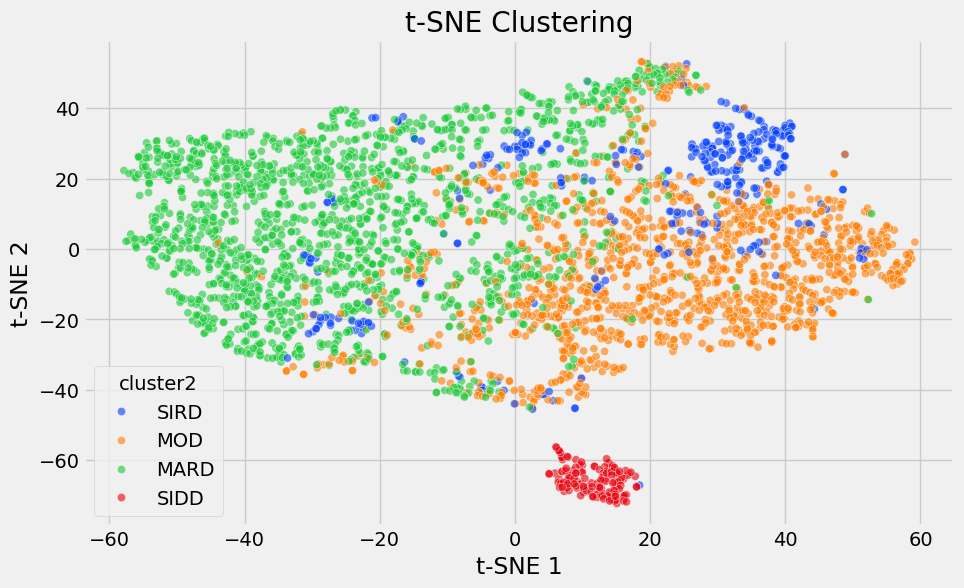

In [88]:
var_drop=['cluster2', 'study_id']
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(data_to_plot2.drop('cluster2', axis=1))

plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=data_to_plot2['cluster2'], palette='bright', alpha=0.6)
plt.title('t-SNE Clustering')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

In [66]:
# compare the two clustring methods
# first rename the cluster labels in the original dataset
data_6c_clean['cluster'] = scaled_data_df['cluster']
data_6c_clean['cluster2'] = scaled_data_df['cluster2']
# relabel the clusters
data_6c_clean['cluster'] = data_6c_clean['cluster'].replace({0:'MOD', 1:'MARD', 2:'SIRD', 3:'SIDD'})
data_6c_clean['cluster2'] = data_6c_clean['cluster2'].replace({0:'MARD', 1:'MOD', 2:'SIRD', 3:'SIDD'})


/var/folders/mw/svm2x9qn5fx658rhfzs94mxh0000gn/T/ipykernel_85478/2793549780.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_6c_clean['cluster'] = scaled_data_df['cluster']
/var/folders/mw/svm2x9qn5fx658rhfzs94mxh0000gn/T/ipykernel_85478/2793549780.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_6c_clean['cluster2'] = scaled_data_df['cluster2']
/var/folders/mw/svm2x9qn5fx658rhfzs94mxh0000gn/T/ipykernel_85478/2793549780.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [65]:
#compare the two clustering methods by selected variables: bmi, hba1c, dmagediag, homa2b, homa2ir
cluster_summary_or_homa2 = data_6c_clean[selected_variables + ['cluster']].groupby('cluster').mean()
print(cluster_summary_or_homa2)
cluster_summary_or_homa2_2 = data_6c_clean[selected_variables + ['cluster2']].groupby('cluster2').mean()
print(cluster_summary_or_homa2_2)



               bmi     hba1c  dmagediag      homa2b   homa2ir
cluster                                                      
MARD     29.070484  6.080186  72.029140   84.328239  1.971429
MOD      37.765280  6.259223  51.837744  134.507916  3.983843
SIDD     35.164593  9.444681  56.916390   52.606383  3.543132
SIRD     34.098166  6.345306  64.652356  314.204898  9.615622
                bmi     hba1c  dmagediag      homa2b   homa2ir
cluster2                                                      
MARD      29.348612  6.119833  72.699249  104.041637  2.576083
MOD       37.465509  6.456589  52.785048  136.309225  4.173889
SIDD      35.179101  6.861654  50.451128   91.037594  2.345791
SIRD      33.728845  6.433238  59.417404  136.160745  4.509836


In [67]:
#compare the two clustering methods by selected variables: bmi, hba1c, dmagediag, ratio_th, sbp, dbp 
cluster_summary_or_homa2 = data_6c_clean[selected_variables2 + ['cluster']].groupby('cluster').mean()
print(cluster_summary_or_homa2)
cluster_summary_or_homa2_2 = data_6c_clean[selected_variables2 + ['cluster2']].groupby('cluster2').mean()
print(cluster_summary_or_homa2_2)


               bmi     hba1c        ldlc       hdlc         tgl         sbp  \
cluster                                                                       
MARD     29.070484  6.080186  102.184021  49.986345  133.315514  127.079016   
MOD      37.765280  6.259223  115.361912  44.694698  161.303958  121.806991   
SIDD     35.164593  9.444681  109.007092  45.078014  160.595745  121.110282   
SIRD     34.098166  6.345306  100.571429  46.971429  158.538776  124.157448   

               dbp  ratio_th  dmagediag  
cluster                                  
MARD     68.985052  2.969973  72.029140  
MOD      80.904687  4.071131  51.837744  
SIDD     81.857975  4.017757  56.916390  
SIRD     71.463774  4.057554  64.652356  
                bmi     hba1c        ldlc       hdlc         tgl         sbp  \
cluster2                                                                       
MARD      29.348612  6.119833   96.540323  51.446595  119.860812  126.976696   
MOD       37.465509  6.456589  12

In [69]:
# cross tabulation of the two clustering methods
ct = pd.crosstab(data_6c_clean['cluster'], data_6c_clean['cluster2'])
print(ct)

cluster2  MARD  MOD  SIDD  SIRD
cluster                        
MARD      1422  163    27   109
MOD         98  965    87   189
SIDD        27   76    18    20
SIRD       127   86     1    31


In [ ]:
# compare the two clustering methods by tsen
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(data_to_plot2.drop('cluster2', axis=1))


In [70]:
# compare the two clustering methods by rand index
from sklearn.metrics import adjusted_rand_score
rand_index = adjusted_rand_score(data_6c_clean['cluster'], data_6c_clean['cluster2'])
print(rand_index)



0.4221959094194046


In [71]:
# The jaccard index is a measure of the similarity between two sets of data. 
# The higher the Jaccard index, the more similar the two sets of data.

from sklearn.metrics import jaccard_score
jac = jaccard_score(data_6c_clean['cluster'], data_6c_clean['cluster2'],average='micro')
print(jac)

0.5466786355475763


In [77]:
# now let's try  kmeans model with six cohorts with LESS Variables
selected_variables3 = ['bmi', 'hba1c', 'dmagediag','sbp','ratio_th']

data_to_cluster3 = scaled_data_df[selected_variables3]

In [78]:
k=4
X3 = data_to_cluster3.values
agg_clustering = AgglomerativeClustering(n_clusters=k, linkage='ward')
agg_labels = agg_clustering.fit_predict(X3)

# Calculate the centroids based on the hierarchical clustering
initial_centroids3 = np.array([X3[agg_labels == i].mean(axis=0) for i in range(k)])


kmeans3 = KMeans(init=initial_centroids3, n_clusters=4, n_init=10, max_iter=300, random_state=57)
kmeans3.fit(data_to_cluster3)

# Add the labels to the scaled dataset
scaled_data_df['cluster3'] = kmeans3.labels_


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1431: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)


In [80]:
cluster_summary3 = scaled_data_df.groupby('cluster3').describe()

# add cluster labels to the original dataset
data_6c_clean['cluster3'] = scaled_data_df['cluster3']
# summarize the data by cluster, show the mean of each variable
cluster_summary_or_homa2_3 = data_6c_clean[selected_variables3 + ['cluster3']+['homa2b']+['homa2ir']].groupby('cluster3').mean()
print(cluster_summary_or_homa2_3)
# save the summary data
cluster_summary_or_homa2_3.to_csv('/Users/zhongyuli/Desktop/python/cluster analysis/dataset/cluster_summary_or_homa2_3.csv')

                bmi     hba1c  dmagediag         sbp   ratio_th      homa2b  \
cluster3                                                                      
0         37.414665  6.247732  51.570641  118.178665   3.210327  140.138141   
1         29.421446  6.102624  72.966864  129.523337   2.799948  103.166857   
2         35.398498  9.497122  57.652272  121.749161   3.817628   74.146763   
3         33.929956  6.268900  57.181044  126.171413  11.322121  143.488038   

           homa2ir  
cluster3            
0         4.068287  
1         2.592895  
2         4.176464  
3         4.712358  


/var/folders/mw/svm2x9qn5fx658rhfzs94mxh0000gn/T/ipykernel_85478/1627285324.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_6c_clean['cluster3'] = scaled_data_df['cluster3']


In [82]:
# cross tabulation of the two clustering methods
data_6c_clean['cluster3'] = data_6c_clean['cluster3'].replace({0:'MOD', 1:'MARD', 2:'SIDD', 3:'SIRD'})
ct2 = pd.crosstab(data_6c_clean['cluster'], data_6c_clean['cluster3'])
print(ct2)

cluster3  MARD   MOD  SIDD  SIRD
cluster                         
MARD      1537   133     0    51
MOD         99  1104     3   133
SIDD         0     9   129     3
SIRD       117    99     7    22


/var/folders/mw/svm2x9qn5fx658rhfzs94mxh0000gn/T/ipykernel_85478/2037919354.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_6c_clean['cluster3'] = data_6c_clean['cluster3'].replace({0:'MOD', 1:'MARD', 2:'SIDD', 3:'SIRD'})


In [83]:
ct3 = pd.crosstab(data_6c_clean['cluster2'], data_6c_clean['cluster3'])
print(ct3)

cluster3  MARD   MOD  SIDD  SIRD
cluster2                        
MARD      1514   132    28     0
MOD        174  1036    78     2
SIDD         0   115    16     2
SIRD        65    62    17   205


In [89]:
rand_index2 = adjusted_rand_score(data_6c_clean['cluster2'], data_6c_clean['cluster3'])
print(rand_index2)

0.547821116478973
